In [1]:
import parse
import analyse
import matplotlib.pyplot as plt
import numpy as np

In [2]:
benchmarks = [
"results/ACASXU_run2a_1_1_batch_2000-retrain-1-0.05",
"results/ACASXU_run2a_1_1_batch_2000-student-1-0.05",
"results/ACASXU_run2a_1_2_batch_2000-retrain-1-0.05",
"results/ACASXU_run2a_1_2_batch_2000-student-1-0.05",
"results/mnist8x8_100_80_60_40_20_10_eps1-9000.2-15",
"results/mnist8x8_student_36_10-9000.7-top",
"results/mnist8x8_student_12_12_12_10-9000.7-top",
"results/mnist8x8_100_80_60_40_20_10-9200.3-top",
#"results/mnist8x8_100_200_300_200_100_10-9200.2-top"
]
variants = [
    'DONT',
    'REFINE_UNTIL_LAST_OPTIMISTIC1',
    'REFINE_UNTIL_MAX',
    'CEGAR_OPTIMAL'
]
commit = '7417a86'
out_handlers=[parse.CegarOptimal]
err_handlers=[parse.RunLim]
both_handlers=[parse.NNEquivResultHandler]
num_runs=3

In [3]:
variant_runs = {}
for v in variants:
    variant_runs[v]={}
    for b in benchmarks:
        variant_runs[v][b]=[]
        for i in range(1,num_runs+1):
            try:
                variant_runs[v][b].append(
                    parse.BenchmarkRun(
                        "../"+b+"-"+v+"/"+str(i)+"/nnequiv-"+commit+"/stdout.log",
                        "../"+b+"-"+v+"/"+str(i)+"/nnequiv-"+commit+"/stderr.log",
                        out_handlers=out_handlers,
                        err_handlers=err_handlers,
                        both_handlers=both_handlers
                    )
                )
            except FileNotFoundError:
                print(f"Count not find "+b+"-"+v+"/"+str(i)+"/nnequiv-"+commit+"/stdout.log")

In [4]:
variants_median = {}
for v in variants:
    variants_median[v]={}
    for b in benchmarks:
        variants_median[v][b]=parse.AggregateRun(variant_runs[v][b])

print(variants_median["DONT"]["results/ACASXU_run2a_1_1_batch_2000-retrain-1-0.05"].get_val(['runlim','real']))

5713.36


In [5]:
from cycler import cycler

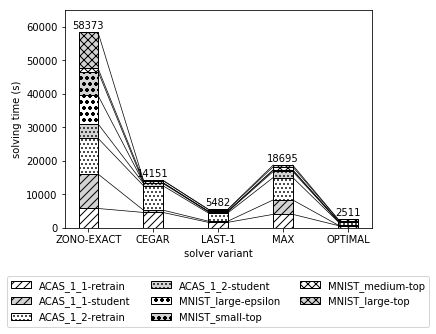

In [11]:
#'--'
#bar_cycle = (cycler('hatch', ['///', '...','oo', 'xxx', '**', '|||', '+++','\\\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
bar_cycle = (cycler('hatch', ['///', '...','oo', 'xxx']) * cycler('color', ['w','lightgrey'])*cycler('zorder', [10]))
styles = bar_cycle()
variants = [
    'DONT',
    'CEGAR',
    'REFINE_UNTIL_LAST_OPTIMISTIC1',
    'REFINE_UNTIL_MAX',
    'OPTIMAL',
]
labels = [
    'ZONO-EXACT',
    'CEGAR',
    'LAST-1',
    'MAX',
    'OPTIMAL'
]
benchmarks_labels = {
"results/ACASXU_run2a_1_1_batch_2000-retrain-1-0.05":"ACAS_1_1-retrain",
"results/ACASXU_run2a_1_1_batch_2000-student-1-0.05":"ACAS_1_1-student",
"results/ACASXU_run2a_1_2_batch_2000-retrain-1-0.05":"ACAS_1_2-retrain",
"results/ACASXU_run2a_1_2_batch_2000-student-1-0.05":"ACAS_1_2-student",
"results/mnist8x8_100_80_60_40_20_10_eps1-9000.2-15":"MNIST_large-epsilon",
"results/mnist8x8_student_36_10-9000.7-top":"MNIST_small-top",
"results/mnist8x8_student_12_12_12_10-9000.7-top":"MNIST_medium-top",
"results/mnist8x8_100_80_60_40_20_10-9200.3-top":"MNIST_large-top",
"results/mnist8x8_100_200_300_200_100_10-9200.2-top":"MNIST_larger-top"
}
width=0.3
fig, ax = plt.subplots()
bottom = [0.0]*len(labels)
for b in benchmarks:
    vals = []
    last_val = None
    for i,l in enumerate(variants):
        if l == 'CEGAR':
            v = variants_median['CEGAR_OPTIMAL'][b].get_val(['cegaropt','cegar'],strategy='M')
            if v is not None:
                vals.append(v)
            else:
                vals.append(0)
                print("Excluding CEGAR "+b)
        elif l == 'OPTIMAL':
            v = variants_median['CEGAR_OPTIMAL'][b].get_val(['cegaropt','opt'],strategy='M')
            if v is not None:
                vals.append(v)
            else:
                vals.append(0)
                print("Excluding OPTIMAL "+b)
        else:
            v = variants_median[l][b].get_val(['runlim','real'],strategy='M')
            vals.append(v)
        if i >= 1:
            ax.plot([i-1+(width/2),i-(width/2)],[last_val+bottom[i-1], v+bottom[i]],color='black',linewidth=0.7)
        last_val=v
    if benchmarks_labels[b]=="MNIST_larger-top":
        print("larger")
        print(vals)
    ax.bar(labels, vals, 0.3, label=benchmarks_labels[b], bottom=bottom, linewidth=1, edgecolor='black', **next(styles))
    bottom=np.array(bottom)+np.array(vals)
for i, b in enumerate(bottom):
    ax.text(i, b+500,
                f"{b:.0f}",
                ha='center', va='bottom', rotation=0)
#ax.set_yscale('log')
fig.set_figwidth(5.5)
fig.set_figheight(4)
plt.ylim((0,65000))
ax.set_ylabel('solving time (s)')
ax.set_xlabel('solver variant')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),ncol=3)
plt.show()